In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

In [ ]:
# συνάρτηση που υπολογίζει την συνάρτηση που υπολογίζουν οι νευρώνες του κρυφού επιπέδου
# Χ είναι το διάνυσμα εισόδου 
# c είναι το διάνυσμα του κέντρου της συστάδας
# b ο αριθμός 1/2σ^2 για κάθε συστάδα
def rbf(X,c,b):
  temp = -b * np.sum(np.square(X - c))
  return np.exp(temp)

REGRESSION PROBLEM

In [ ]:
# φόρτωση δεδομένων
data =  pd.read_csv("data.csv",delimiter=',')

data = data.dropna() # διαγραφή γραμμών με NaN εγγραφές

X = data.drop(columns=['close','time']) # είσοδος
y = data['close'] # έξοδος

# κρατάμε τις πρώτες 60000 εγγραφές
X = np.array(X[0:60000])
y = np.array(y[0:60000])

reg = StandardScaler() # για την κανονικοποίηση

ΑΞΙΟΛΟΓΗΣΗ ΜΕ TIMESERIES_SPLIT

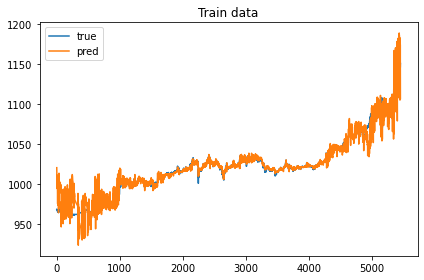

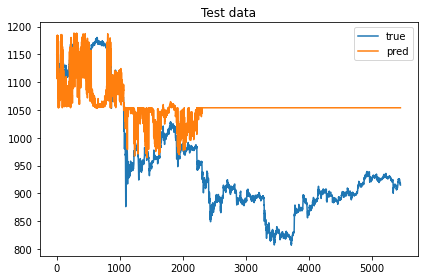

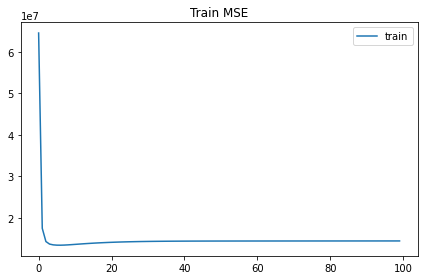

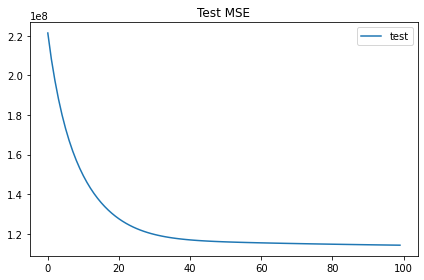

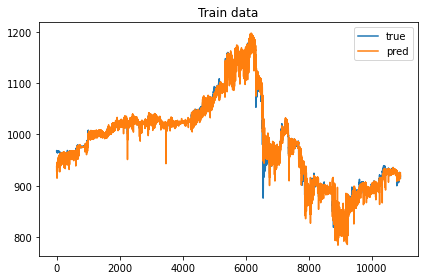

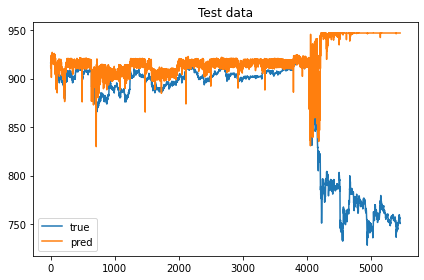

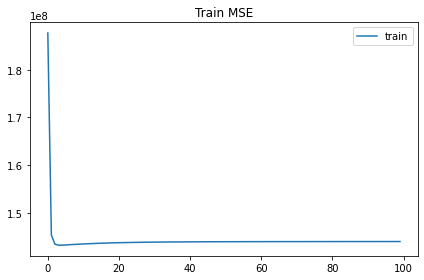

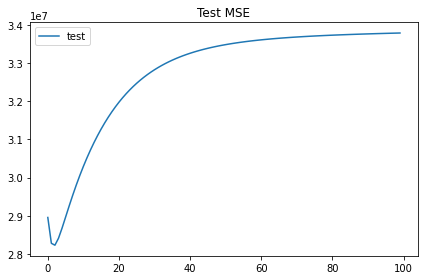

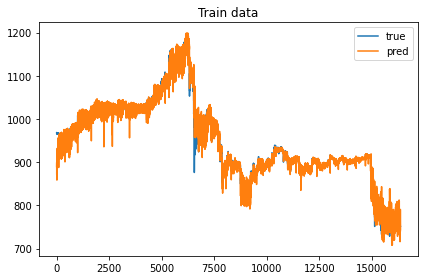

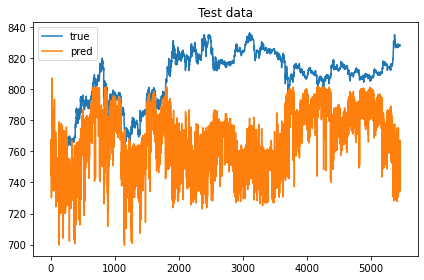

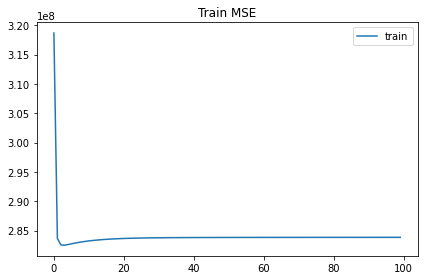

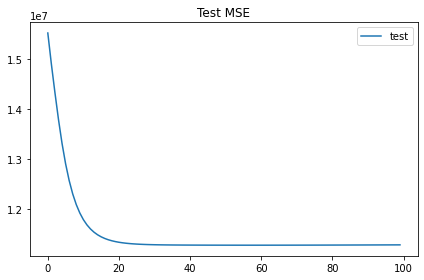

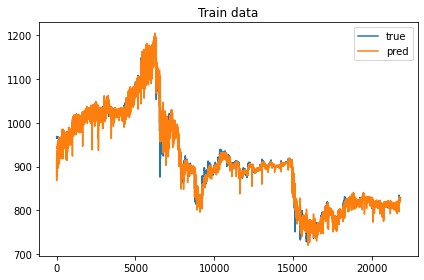

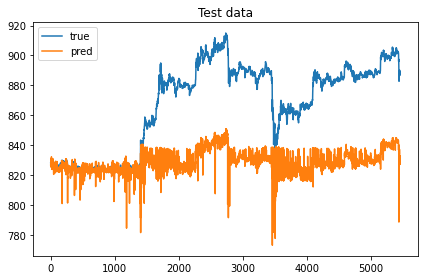

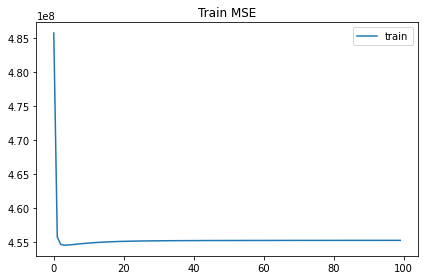

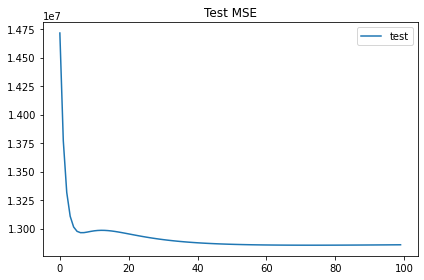

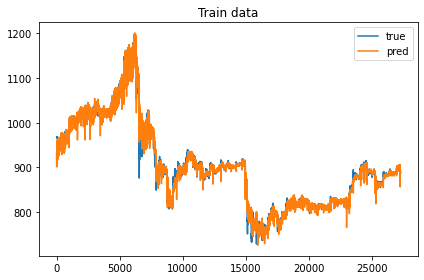

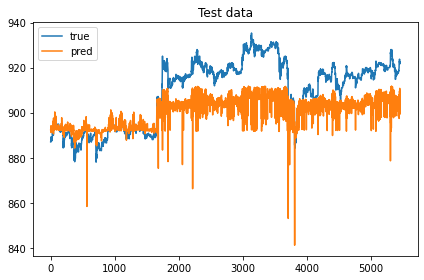

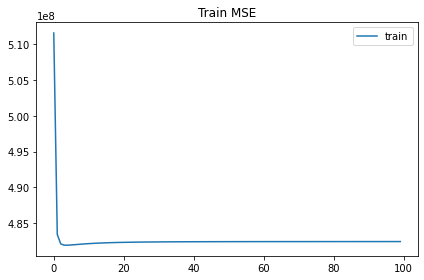

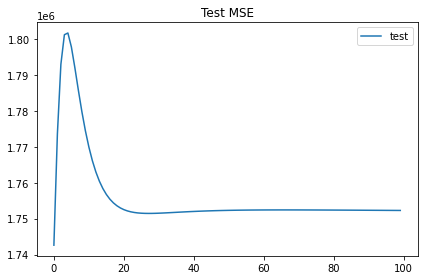

In [ ]:
learning_rate = 0.01 # βαθμός μάθησης
epochs = 100 #εποχές

kf = TimeSeriesSplit(n_splits=10) # για τον διαχωρισμό δεδομένων εκπαίδευσης και δεδομένων ελέγχου

time = [[i] for i in range(0,60000)] # στήλη για τον χρόνο
Χ = np.append(X,time,axis=1)
# πρόβλεψη τιμής με TimeSeriesSplit
for train, test in kf.split(X):
  train_X, test_X, train_y, test_y = X[train], X[test], y[train], y[test]
  train_X = reg.fit_transform(train_X)
  test_X = reg.transform(test_X)
  # εκπαίδευση κρυφού επιπέδου
  k = 50
  kmeans = KMeans(n_clusters=k).fit(train_X)
  centers = kmeans.cluster_centers_
  labels = kmeans.labels_

  # εύρεση διασποράς για κάθε συστάδα
  variance = []

  for c in range(k):
    cluster = train_X[labels == c]
    v = np.sum(np.square(cluster - centers[c])) / len(cluster)
    variance.append(v)


  variance = np.array(variance)
  # ευρεση 1/2σ^2 που χηριμοποιούμε στην συνάρτηση rbf
  b = 1 / (2 * variance + 1e-10) # προσθέτουμε ένα πολύ μικρό αριθμό στην περιπτωση που η διασπορα είναι 0

  weights = np.random.randint(size=(k,1),low=0,high=10) #βάρη
  bias = np.random.randn(1) # bias
  hidden_layer = np.empty(shape=(k,1)) # κρυφό επίπεδο  
  
  # MSE 
  mse_train = []
  mse_test = []
  #εκαπίδευση σε εποχές
  for i in range(epochs):
    output_train = [] # αποτελέσματα για δεδομένα εκπαίδευσης
    for j in range(len(train_X)):
      input_layer = train_X[j] # επίπεδο εισόδου
      for ki in range(k):
        hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki]) # υπολογισμός κρυφού επιπέδου
      output_layer = np.dot(hidden_layer.T,weights) + bias # υπολογισμός εξωτερικού επιπέδου

      output_train.append(output_layer.flatten())

      # error
      output_error = output_layer - train_y[j] 

      # ενημέρωση βαρών
      weights = weights - learning_rate*hidden_layer*output_error
      # ενημέρωση bias
      bias = bias - learning_rate*output_error
    # υπολογισμός MSE για δεδομένα εκπαιδευσης
    output_train = np.array(output_train)
    mse_train.append(np.sum(np.square(output_train-train_y))/ len(train_y)) 

    # πρόβλεψη δεδομένων ελέγχου
    output_test = []
    for j in range(len(test_X)):
      input_layer = test_X[j]
      for ki in range(k):
        hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki])
      output_layer = np.dot(hidden_layer.T,weights) + bias

      output_test.append(output_layer.flatten())
    
    # υπολογισμός MSE για δεδομένα ελέγχου
    output_test = np.array(output_test)
    mse_test.append(np.sum(np.square(output_test-test_y))/ len(test_y)) 
  
  # εμφανιση κατάλληλων διαγραμμάτων για τα αποτελέσματα
  plt.plot(range(0,len(train_X)), train_y, label='true')
  plt.plot(range(0,len(train_X)),output_train,label='pred')
  plt.title("Train data")
  plt.legend()
 
  plt.tight_layout()
  plt.show()

  plt.plot(range(0,len(test_X)), test_y, label='true')
  plt.plot(range(0,len(test_X)),output_test,label='pred')
  plt.title("Test data")
  plt.legend()
 
  plt.tight_layout()
  plt.show()

  plt.plot(range(0,epochs), mse_train, label='train')
  plt.title("Train MSE")
  plt.legend()
 
  plt.tight_layout()
  plt.show()


  plt.plot(range(0,epochs), mse_test, label='test')
  plt.title("Test MSE")
  plt.legend()
 
  plt.tight_layout()
  plt.show()

ΑΞΙΟΛΟΓΗΣΗ ΜΕ ΥΠΟΣΥΝΟΛΑ

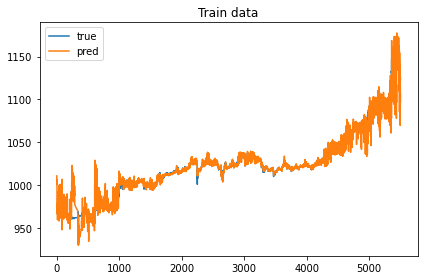

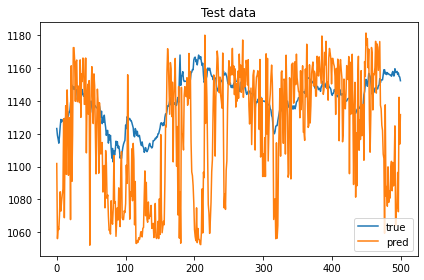

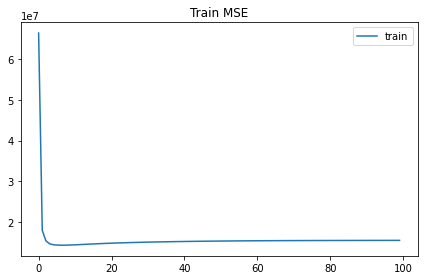

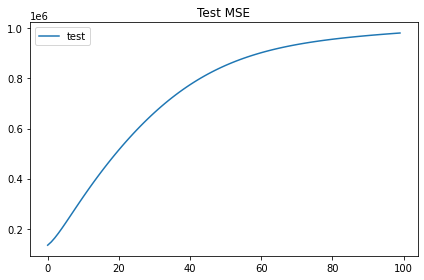

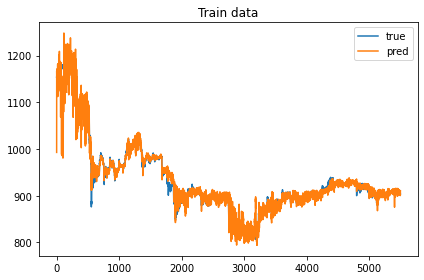

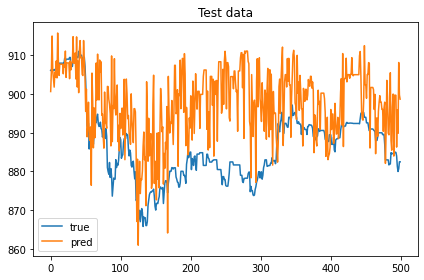

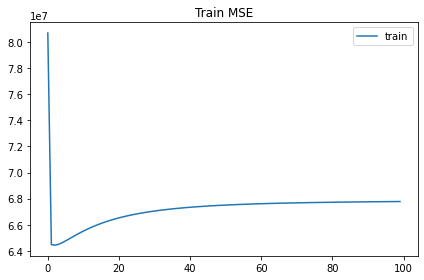

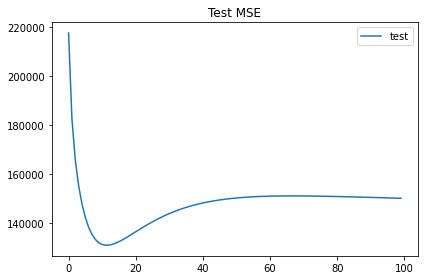

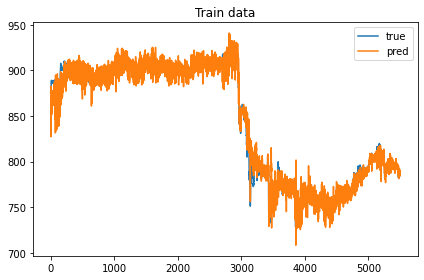

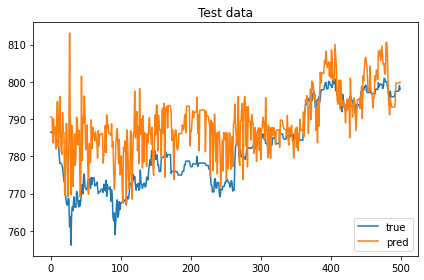

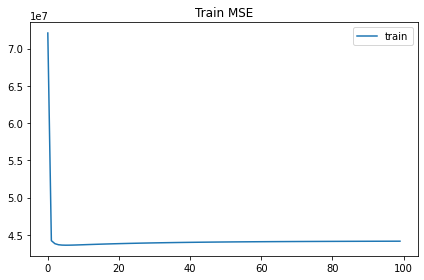

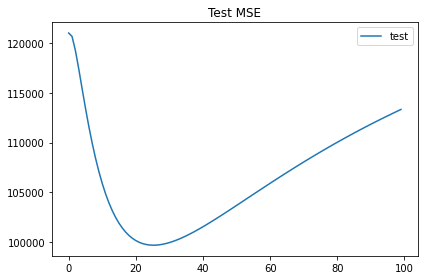

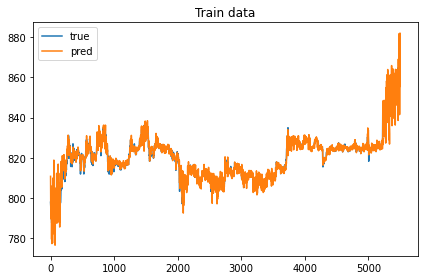

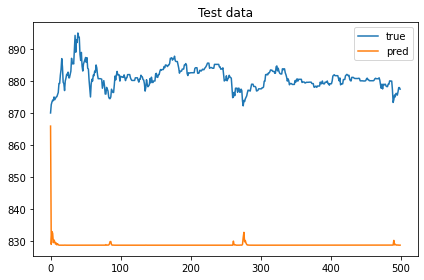

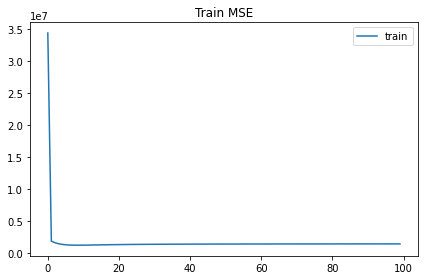

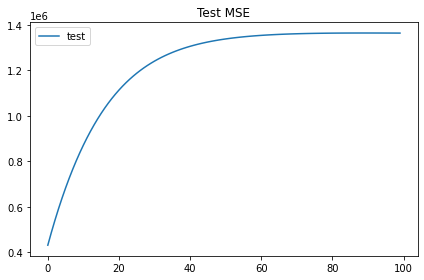

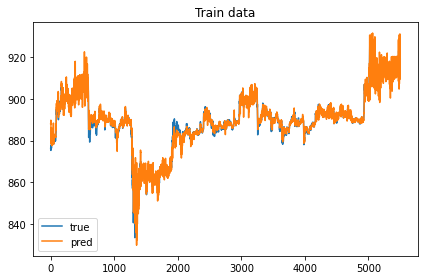

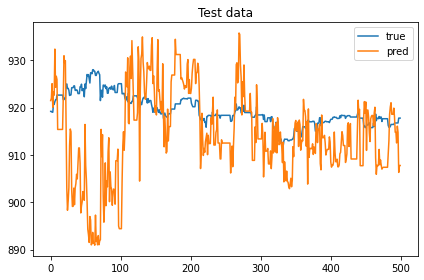

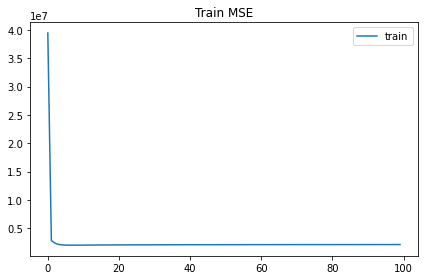

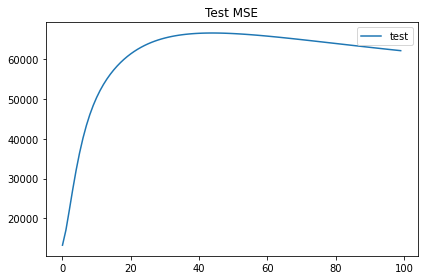

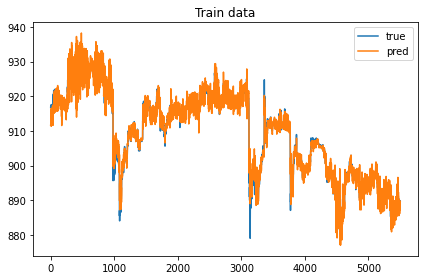

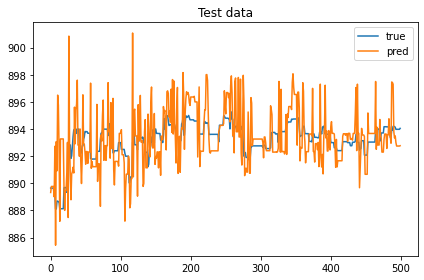

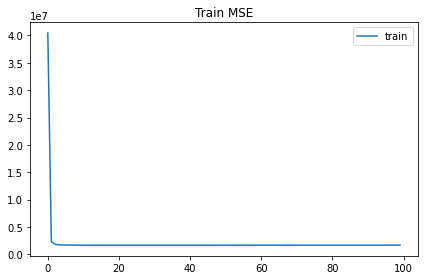

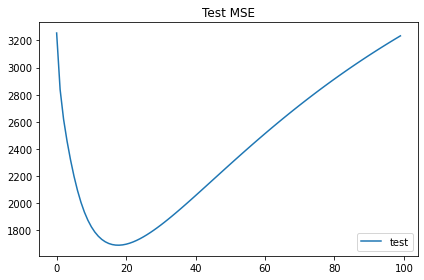

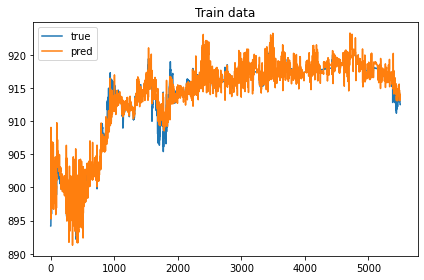

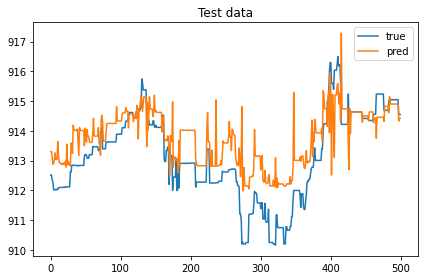

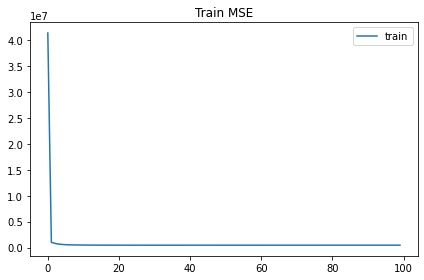

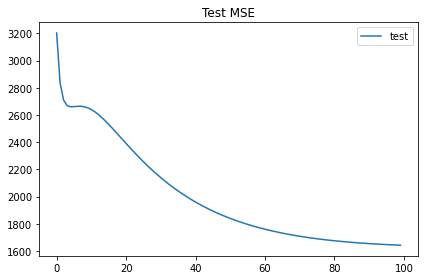

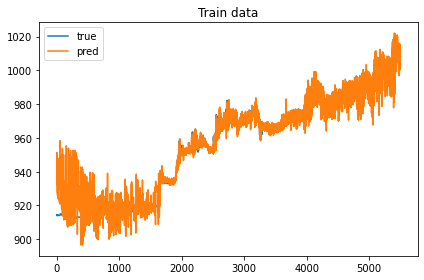

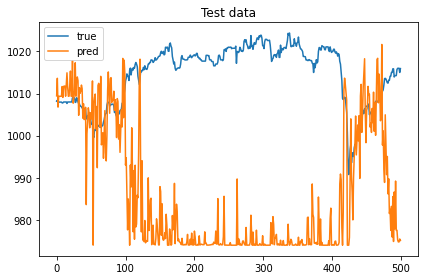

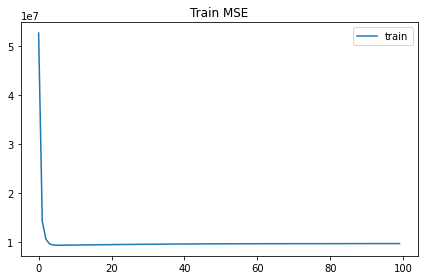

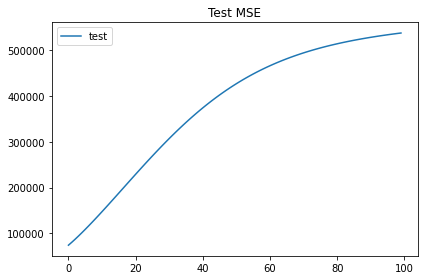

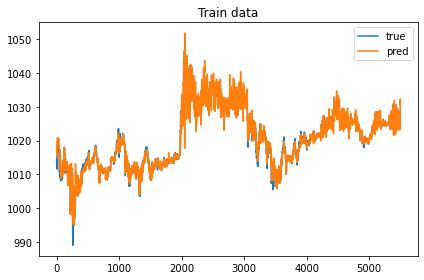

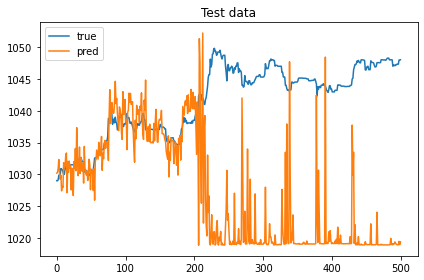

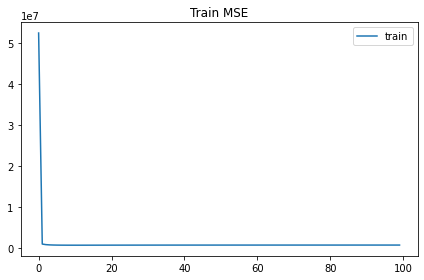

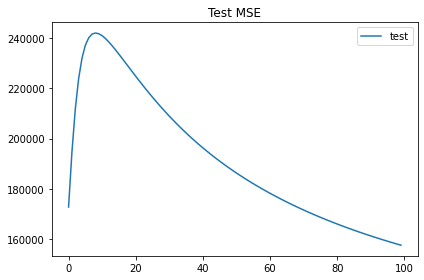

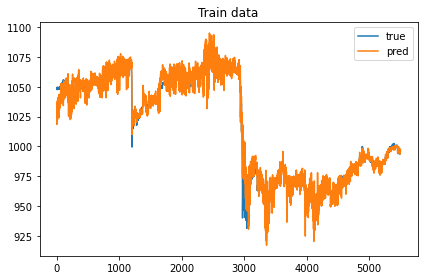

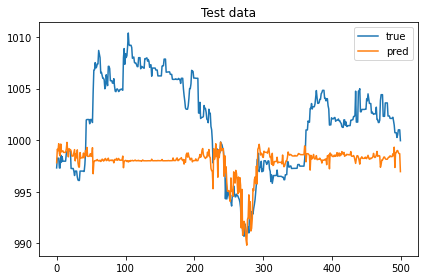

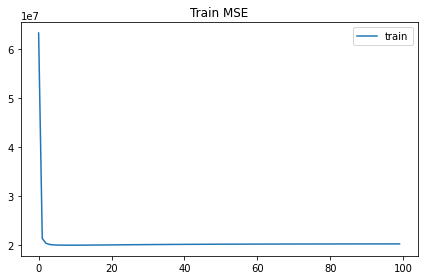

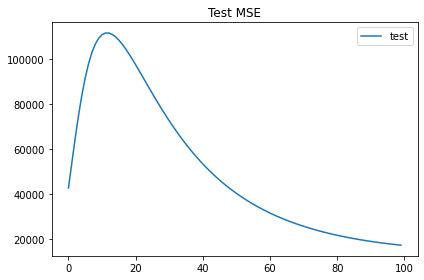

In [ ]:
learning_rate = 0.01 # βαθμός μάθησης
epochs = 100 #εποχές

for n in range(0,60000,6000):
  # διαχωρισμός δεδομένων εκπαίδευσης και δεδομένων ελέγχου και ειγαγωγής στήλης για τον χρόνο
  train_X, test_X, train_y, test_y = X[n:n+5500], X[5500+n:6000+n], y[n:n+5500], y[5500+n:6000+n]
  time = np.array([[i] for x in range(5500)])
  train_X = np.append(train_X,time,axis=1)
  time1 = np.array([[i] for x in range(5500,6000)])
  test_X = np.append(test_X,time1,axis=1)
  
  # κανονικοποίηση
  train_X = reg.fit_transform(train_X)
  test_X = reg.transform(test_X)
  
  # εκπαίδευση κρυφού επιπέδου
  k = 50
  kmeans = KMeans(n_clusters=k).fit(train_X)
  centers = kmeans.cluster_centers_
  labels = kmeans.labels_

 # εύρεση διασποράς
  variance = []

  for c in range(k):
    cluster = train_X[labels == c]
    v = np.sum(np.square(cluster - centers[c])) / len(cluster)
    variance.append(v)

  variance = np.array(variance)
  # ευρεση 1/2σ^2 που χηριμοποιούμε στην συνάρτηση rbf
  b = 1 / (2 * variance + 1e-10) # προσθέτουμε ένα πολύ μικρό αριθμό στην περιπτωση που η διασπορα είναι 0

  weights = np.random.randint(size=(k,1),low=0,high=10) #βάρη
  bias = np.random.randn(1) #bias
  hidden_layer = np.empty(shape=(k,1))  # κρυφό επίπεδο

  # MSE πίνακες
  mse_train = []
  mse_test = []
  for i in range(epochs):
    output_train = [] #αποτελέσματα δεδομένων εκπαίδευσης
    for j in range(len(train_X)):
      input_layer = train_X[j] #επίπεδο εισόδου
      for ki in range(k):
        hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki]) #κρυφό επίπεδο
      output_layer = np.dot(hidden_layer.T,weights) + bias  # εξωτερικό επίπεδο

      output_train.append(output_layer.flatten())

      # error
      output_error = output_layer - train_y[j]

      # ενημέρωση βαρών
      weights = weights - learning_rate*hidden_layer*output_error
      bias = bias - learning_rate*output_error
    # υπολογισμός MSE
    output_train = np.array(output_train)
    mse_train.append(np.sum(np.square(output_train-train_y))/ len(train_y)) 

    # πρόβλεψη δεδομένων ελέγχου
    output_test = []
    for j in range(len(test_X)):
      input_layer = test_X[j]
      for ki in range(k):
        hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki])
      output_layer = np.dot(hidden_layer.T,weights) + bias

      output_test.append(output_layer.flatten())
    
    # υπολογισμός MSE για τα δεδομένα ελέγχου
    output_test = np.array(output_test)
    mse_test.append(np.sum(np.square(output_test-test_y))/ len(test_y)) 
  
  # εμφάνιση διαγρμμάτων για την αξιολόγηση των αποτελεσμάτων
  plt.plot(range(0,len(train_X)), train_y, label='true')
  plt.plot(range(0,len(train_X)),output_train,label='pred')
  plt.title("Train data")
  plt.legend()
 
  plt.tight_layout()
  plt.show()

  plt.plot(range(0,len(test_X)), test_y, label='true')
  plt.plot(range(0,len(test_X)),output_test,label='pred')
  plt.title("Test data")
  plt.legend()
 
  plt.tight_layout()
  plt.show()

  plt.plot(range(0,epochs), mse_train, label='train')
  plt.title("Train MSE")
  plt.legend()
 
  plt.tight_layout()
  plt.show()


  plt.plot(range(0,epochs), mse_test, label='test')
  plt.title("Test MSE")
  plt.legend()
 
  plt.tight_layout()
  plt.show()


CLASSIFICATION PROBLEM

In [ ]:
# φόρτωση δεδομένων
(train_X, train_y), (test_X, test_y) = mnist.load_data()

classes = 10 #αριθμός κλάσεων

# κανονικοποίηση δεδομένων
train_X = train_X.reshape(train_X.shape[0],784) / 255
test_X = test_X.reshape(test_X.shape[0],784) / 255

# μετατροπή label σε one hot encoding
train_y = to_categorical(train_y,classes)
test_y = to_categorical(test_y,classes)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# εκπαίδευση κρυφού επιπέδου χρησιμοποιώντας τον αλγόριθμο kmeans 
k = 200
#train_X = train_X.reshape(-1,1)
kmeans = KMeans(n_clusters=k).fit(train_X)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# εύρεση διασποράς για κάθε συστάδα
variance = []

for i in range(k):
  cluster = train_X [labels == i]
  v = np.sum(np.square(cluster - centers[i])) / len(cluster)
  variance.append(v)

variance = np.array(variance)
# ευρεση 1/2σ^2 που χηριμοποιούμε στην συνάρτηση rbf
b = 1 / (2 * variance + 1e-10) # προσθέτουμε ένα πολύ μικρό αριθμό στην περιπτωση που η διασπορα είναι 0

In [13]:
n_samples = len(train_X) # αριθμός εγγραφών δεδομένων εκπαίδευσης
weights = np.random.randint(size=(k,classes),low=0,high=10) #βάρη 
bias = np.random.randint(size=(classes),low=0,high=10) # bias
hidden_layer = np.empty(shape=(k,1)) # πίνακας για το κρυφό επίπεδο
learning_rate = 0.01 # βαθμός μάθησης
epochs = 100 #εποχές

In [ ]:
# πίνακες για την απόδοση των δεδομένων ελέγχου
mse_test = [] 
accuracy_test = []
# πίνακες για την απόδοση των δεδομένων εκπαίδευσης
mse_train = []
accuracy_train = []
for i in range(epochs):
  output_train = [] # αποτελέσματα για τα δεδομένα εκπαίδευσης
  for j in range(n_samples):
    input_layer = train_X[j] # επίπεδο εισόδου
    for ki in range(k):
      hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki]) # υπολογισμός κρυφού επιπέδου
    output_layer = np.dot(hidden_layer.T,weights) + bias # υπολογισμός εξωτερικού επιπέδου

    output_train.append(output_layer) 

    output_error = output_layer - train_y[j] # error

    # ενημέρωση βαρών
    weights = weights - learning_rate*np.dot(hidden_layer,output_error)
    bias = bias - learning_rate*output_error

  output_train = np.array(output_train)
  
  # υπολογισμός MSE για τα δεδομένα εκπαίδευσης
  output_train = output_train.reshape(n_samples,classes)
  mse_train.append(np.sum(np.square(output_train-train_y)) / n_samples)
  
  # υπολογισμός απόδοσης στα δεδομένα εκπαίδευσης (ως απόφαση του νευρωνικού θεωρούμε την κλάση που αντιστοιχεί στον νευρώνα που έχει την μεγαλύτερη τιμή)
  output_train = to_categorical(np.argmax(output_train,axis=1),classes)
  accuracy_train.append(accuracy_score(train_y,output_train))
  
  # πρόβλαψη για τα δεδομένα ελέγχου
  output_test = []
  n_samples_test = test_X.shape[0]
  for j in range(n_samples_test):
      input_layer = test_X[j]
      for ki in range(k):
        hidden_layer[ki] = rbf(input_layer,centers[ki],b[ki])
      output_layer = np.dot(hidden_layer.T,weights) + bias

      output_test.append(output_layer)

  output_test = np.array(output_test)
  
  # υπολογισμός MSE για τα δεδομένα ελέγχου
  output_test = output_test.reshape(n_samples_test,classes)
  mse_test.append(np.sum(np.square(output_test-test_y)) / n_samples_test)

  # υπολογισμός απόδοσης στα δεδομένα ελέγχου
  output_test = to_categorical(np.argmax(output_test,axis=1),classes)
  accuracy_test.append(accuracy_score(test_y,output_test))

In [ ]:
# εμφάνιση αποτελεσμάτων
plt.plot(range(0,epochs), accuracy_train, label='train')
plt.plot(range(0,epochs),accuracy_test,label='test')
plt.title("Accuracy")
plt.legend()
 
plt.tight_layout()
plt.show()


plt.plot(range(0,epochs), mse_train, label='train')
plt.plot(range(0,epochs),mse_test,label='test')
plt.title("MSE")
plt.legend()
 
plt.tight_layout()
plt.show()

ΚΑΤΗΓΟΡΙΟΠΟΗΤΕΣ ΚΝΝ ΚΑΙ NEAREST CENTROID

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

classes = 10

train_X = train_X.reshape(train_X.shape[0],784) / 255
test_X = test_X.reshape(test_X.shape[0],784) / 255

1 - ΠΛΗΣΙΕΣΤΕΡΟΣ ΓΕΙΤΟΝΑΣ

In [ ]:
clf = KNeighborsClassifier(n_neighbors=1,p=2)
clf.fit(train_X,train_y)
predicted = clf.predict(test_X)

print("Accuracy %f" %(accuracy_score(test_y,predicted)))

Accuracy 0.969100


3 - ΠΛΗΣΙΕΣΤΕΡΟΙ ΓΕΙΤΟΝΕΣ

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3,p=2)
clf.fit(train_X,train_y)
predicted = clf.predict(test_X)

print("Accuracy %f" %(accuracy_score(test_y,predicted)))

Accuracy 0.970500


ΠΛΗΣΙΕΣΤΕΡΟ ΚΕΝΤΡΟ

In [ ]:
clf = NearestCentroid(metric='euclidean')
clf.fit(train_X,train_y)
predicted = clf.predict(test_X)

print("Accuracy %f" %(accuracy_score(test_y,predicted)))

Accuracy 0.820300
